# 5.3 基于迁移学习技术来识别猫狗

## 在段到段的模式下定义基于SVC的分类器

## 1 创建VGG16卷积基实例（即仅使用卷积层，而不使用全连接层作为分类器）

In [8]:
from keras.applications import VGG16

In [9]:
#创建VGG16实例，提前下载VGG16模型的h5文件，然后放置在C:\Users\Administrator\.keras\models
#include_top：是否包含全连接层
#weights：模型初始权重
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

### 通过函数summary回顾下卷积基的网络结构

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### vgg16的卷积核包含5部分：
### 第1-2部分：Conv2D x 2 + MaxPooling2D
### 第3-5部分：Conv2D x 3 + MaxPooling2D
### 卷积核的输出特征维度为 4 x 4 x 512, 我们需要在此基础上添加自定义的Dense层来实现分类器

## 2 使用预训练的VGG16模型的卷积基进行特征提取

In [11]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

### 设置训练集、验证集、测试集的图片目录

In [12]:
base_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

### 创建数据生成器实例

### 场景1：不使用数据增强技术

In [13]:
#实例化ImageDataGenerator，不使用数据增强技术
datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
generator = datagen.flow_from_directory(test_dir,
                                           target_size = (150,150),
                                           batch_size = 20,
                                           class_mode = 'binary')

Found 1000 images belonging to 2 classes.


### 场景2：使用数据增强技术

In [8]:
#使用数据增强技术
# datagen = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 40,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     shear_range = 0.2,
#     zoom_range = 0.2,
#     horizontal_flip = True,
#     fill_mode = 'nearest')

### 定义特征提取函数
### 基于数据生成器将图像张量批量输入至卷积基，通过函数predict获取卷积基的特征张量
### 输入：提取图片样本目录；提取样本数
### 输出：返回VGG16卷积基输出的张量；样本对应的分类结果

In [15]:
#定义特征提取函数

batch_size = 20

#通过指定路径获取样本数进行特征提取
def extract_features(directory, sample_count):
    #初始化features,labels矩阵
    features_vgg16 = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    #生成器加载
    generator = datagen.flow_from_directory(directory,
                                           target_size = (150,150),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0
    for fs,ls in generator:
        vgg16_output = conv_base.predict(fs) 
        features_vgg16[i*batch_size : (i+1)*batch_size] = vgg16_output
        labels[i*batch_size : (i+1)*batch_size] = ls
        i+=1
        if i*batch_size >= sample_count:
            break
    return features_vgg16,labels
    

In [66]:
# #定义特征提取函数

# #batch_size = 20

# #通过指定路径获取样本数进行特征提取
# def extract_features2(directory, sample_count):
    
    
#     #生成器加载
#     datagen = ImageDataGenerator(rescale = 1./255)
#     generator = datagen.flow_from_directory(directory,
#                                            target_size = (150,150),
#                                            batch_size = 20,
#                                            class_mode = 'binary')
#     batch_size = 20
#     labels = np.zeros(shape = (sample_count))
#     i = 0
#     for fs,ls in generator:
#         labels[i*batch_size : (i+1)*batch_size] = ls
#         i+=1
#         if i*batch_size >= sample_count:
#             break
#     return labels
    

### 对训练集、验证集、测试集进行特征提取

In [16]:
#对训练集、验证集、测试集进行特征提取
train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
train_features

array([[[[5.13367653e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.32555008e-01, 0.00000000e+00],
         [1.23180652e+00, 0.00000000e+00, 3.02354187e-01, ...,
          0.00000000e+00, 2.99146235e-01, 0.00000000e+00],
         [2.20754528e+00, 0.00000000e+00, 9.90331650e-01, ...,
          0.00000000e+00, 3.38175148e-01, 0.00000000e+00],
         [3.39959645e+00, 0.00000000e+00, 1.85085654e-01, ...,
          0.00000000e+00, 5.01535296e-01, 0.00000000e+00]],

        [[5.79645753e-01, 0.00000000e+00, 4.74496067e-01, ...,
          0.00000000e+00, 7.81110466e-01, 0.00000000e+00],
         [1.63553286e+00, 0.00000000e+00, 2.15437531e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.04573059e+00, 0.00000000e+00, 2.16922522e+00, ...,
          0.00000000e+00, 4.15283829e-01, 0.00000000e+00],
         [2.42117190e+00, 0.00000000e+00, 6.75863266e-01, ...,
          0.00000000e+00, 3.01530778e-01, 0.00000000e+00]],

        [[6.47521615

In [18]:
train_labels

array([1., 1., 0., ..., 0., 0., 1.])

## 3 创建自定义的分类器


### 3.1 展平卷积基张量
### 注意：VGG16特征提取后的形状为(samples, 4, 4, 512), 因此在输入到分类器之前需要先展平
### (样本数, 4, 4, 512) 四维张量 -----> (样本数, 4 x 4 x 512 = 8192)

In [19]:
train_features_reshaped = np.reshape(train_features, (2000, 8192))
validation_features_reshaped = np.reshape(validation_features, (1000, 8192))
test_features_reshaped = np.reshape(test_features, (1000, 8192))

In [20]:
train_features_reshaped.shape

(2000, 8192)

### 3.2 创建SVC定义分类器

In [21]:
from sklearn import svm

clf = svm.SVC(kernel = 'rbf')

## 4 训练SVC

In [22]:
#训练参数：
#-迭代次数
#-批量大小
#-验证集
import time
start = time.time()

history_svc = clf.fit(train_features_reshaped,train_labels)

end = time.time()
print("训练时间（s）：%d"%(end - start))

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


训练时间（s）：21


### 采用支持向量机进行段到段的分类模型训练时间约为 21s

### 查看训练集分类准确率

In [23]:
clf.score(train_features_reshaped,train_labels)

0.898

### 查看验证集分类准确率

In [24]:
clf.score(validation_features_reshaped,validation_labels)

0.878

### 查看测试集分类准确率

In [26]:
clf.score(test_features_reshaped,test_labels)

0.873

## 5 评估模型

### 5.1 评估分类准确率

#### 方法1：score()

In [43]:
clf.score(train_features_reshaped,train_labels)

0.898

In [44]:
clf.score(validation_features_reshaped,validation_labels)

0.878

In [45]:
clf.score(test_features_reshaped,test_labels)

0.873

#### 方法2：accuray_score()

In [27]:
#也可以通过accuracy_score函数
from sklearn.metrics import accuracy_score
accuracy_score(clf.predict(test_features_reshaped), test_labels)

0.873

#### 方法3：将每个输入通过conv_base、SVC，得到预测值，再与真实值比较

In [46]:
import os
from keras.preprocessing import image

classes = ['cats','dogs']
files_name = []
test_true_labels = []
test_pred_labels = []
test_pred_probs = []

for c in classes:
    test_class_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/{}'.format(c)
    for f in os.listdir(test_class_dir):
        
        files_name.append(f)
        test_true_labels.append(f[0:3])
        
        img_path = os.path.join(test_class_dir, f)
        img = image.load_img(img_path, target_size = (150, 150))
        #预处理图片&提取卷积基特征
        extracted_features = conv_base.predict(preprocess_img(img))
        #展平张量
        input_features = np.reshape(extracted_features, (1,8192))
        #模型预测
        pred = clf.predict(input_features)
        test_pred_probs.append(pred)
        
        pred_label = None
        if pred[0] == 0. :
            pred_label = 'cat'
        else:
            pred_label = 'dog'
        test_pred_labels.append(pred_label)  

In [48]:
import pandas as pd
df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
pred_correct_records = df[df['true_label'] == df['pred_label']].shape[0]
correct_rate = float(pred_correct_records)/float(1000)
correct_rate

0.873

#### 查看分类错误的图片

In [ ]:
df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'cat')]

#对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
files_error = list(df_error_sample['file'])
true_labels_error =  list(df_error_sample['true_label'])
pred_labels_error =  list(df_error_sample['pred_label'])
pred_probs_error = list(df_error_sample['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 4
n_cols= 4 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/cats/{}'.format(files_error[c])
        image_error = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(image_error);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
        c+=1

### 5.2 评估部分测试照片

In [28]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

#### 测试图片1

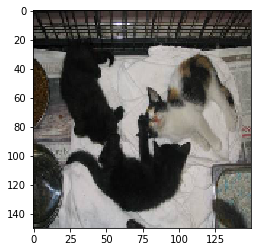

In [30]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/cats/cat.12436.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [31]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = clf.predict(input_features)
pred

array([0.])

#### 特别注意，与全连接型分类器相比，支持向量分类机输出预测分类结果为二元结果，即0.或1.，而不是介于[0,1]之间的概率

#### 测试图片2

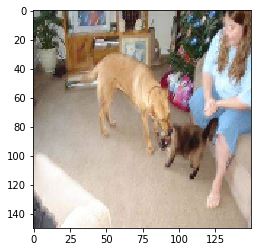

In [32]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [33]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = clf.predict(input_features)
pred

array([1.])

#### 模型在上述图像中优先识别出了狗

#### 测试图片3

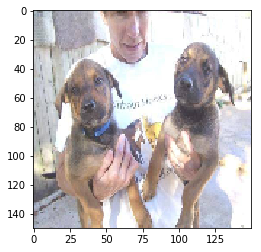

In [39]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12003.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [40]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = clf.predict(input_features)
pred

array([1.])

#### 上述照片分类预测概率为1，即模型预测为狗，分类正确